# Computing Differential Privacy budget with PyTorch-DP
_This notebook is supposed to take place in `pytorch-dp/torchdp/scripts/` directory, see [GitHub of PyTorch-DP](https://github.com/facebookresearch/pytorch-dp/scripts/) to get the code._

In [1]:
# == Usual basic tools ==
import math
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
# For adaptation to your screen (for matplotlib plots), see next cell
_DPI = plt.rcParams['figure.dpi']

# General tools for DP accouting
from torchdp import privacy_analysis as tf_privacy

# Direct computation for Stochastic Gradient Descent - Local module
import compute_dp_sgd_privacy as co

In [2]:
# Adaptation to your screen if necessary (for matplotlib plots)

# (Not in the same cell as above, to avoid cumulating zooms 
#      when iterating modifications on _zoom value)

# Your factor of modification
_zoom = 1.4

# Modify
plt.rcParams['figure.dpi'] = int(_DPI * _zoom)

--- 
## A short demo to begin with
---
Let's compute a $\varepsilon$ so as $(\varepsilon,\delta)$-DP is proven for a Differential Private Stochastic Gradient Descent, if its gradient (_the function to be privacy wise protected here_) has a $\ell_2$-sensitivity of $1$.
* training dataset size = 15000
* batch size = 250
* noise multiplier for Gaussian noise (added to clipped gradients) = 1.3
* number of epochs = 15
* targetted $\delta$ is 1e-5

*Let's use a dedicated function we build from the similar one [in TensoFlow-privacy project](https://github.com/tensorflow/privacy/blob/master/tensorflow_privacy/privacy/analysis/compute_dp_sgd_privacy.py). The associated "RDP order" mentioned in answer is explained in next paragraph*.

<div style="text-align: center; font-size: 120%; color: blue; font-weight: bold; font-style: italic;">
Here are some default values for a Sampled Gaussian Mechanism.<br>
They can be modified, but be aware that cells are mainly supposed to be executed sequentially.
</div>

In [3]:
dataset_size, batch_size = 15000, 250
noise_multiplier, epochs, delta = 1.3, 15, 1e-5

In [4]:
co.compute_dp_sgd_privacy(dataset_size, batch_size, noise_multiplier, epochs, delta)

# Facultative arguments you may test
# . alphas   
#       non default RDP orders values to compute best (Ɛ,δ)-DP
#       ex.   alphas=[1.25, 1.5, 2.0, 3.0, 5.0]
# . printed  
#       boolean, to print results, or else just return the (Ɛ, α) tuple
#       True (default) or False

DP-SGD with
	sampling rate = 1.67% and
	noise_multiplier = 1.3
	iterated over 900 steps
  satisfies differential privacy with
	Ɛ = 2.46 and
	δ = 1e-05.
  The optimal α is 10.0.


(2.4614490035755816, 10.0)

>*__Remarks__*
>
>It is also possible to call `compute_dp_sgd_privacy.py` file directly __in a shell__
>
>*(Either make it executable before, with **`chmod +x compute_dp_sgd_privacy.py`**, either add `python` before the `.py` file name), with arguments given on the command line if necessary (use **`-h`** argument to get details about them).*
>
>_The `!` here in first place allows a shell command execution from the Python notebook, don't use it in a genuine shell._

In [5]:
!./compute_dp_sgd_privacy.py -s 15000 -b 250 -n 1.3 -e 15

./compute_dp_sgd_privacy.py: 1: ./compute_dp_sgd_privacy.py: Syntax error: end of file unexpected


This function provides directly a privacy budget consumption without launching a long training on a neural network. But under the hood it uses the same functions as many deep learning models use, with a training phase based on Stochastic Gradient Descent. If you are interested in how previous values are determined, let's go on...

As far as I know, one of the main reference about privacy with SGD is **"_Deap Learning with Differential Privacy_"** (**Abadi** _et al._, **2016**, **[arXiv:1607.00133](https://arxiv.org/pdf/1607.00133)** _alias_ **[A16]**), see **Algorithm 1** in **section 3.1** for the details about how to clip gradient, then add random noise, to get privacy. 

For his part, **Nicolas Papernot** wrote an easy to read article (on [tensorflow/privacy GitHub](github.com/tensorflow/privacy/tree/master/tutorials/walkthrough)), clearly explaining the vanilla SGD and then how to transform it into a Differentially Private algorithm. His paper's snippets are based on TensorFlow, not PyTorch, but _pytorch-dp_ has roots in _TensorFlow Privacy_ (some portions of code are common) and except some differences in code extracts, the explanations in this article are still relevant. I also love the [3blue1brown Youtube videos](https://www.youtube.com/watch?v=aircAruvnKk) about the basis of deep learning. 

_OK that's all about ads_ :-)

--- 
## Let's dive into the magic of Differential Privacy
---
### RDP ~~_vs_~~ serving $(\varepsilon, \delta)$-DP
Both formalizations of Differential Privacy are involved here: **the result is expressed in $(\varepsilon, \delta)$-DP terms**, because it is quite understandable (_say, better than more complicated ways of expressing DP_ :wink: !) 

It is possible to compute the consumption of "privacy budget" for each loop (each application of Gaussian mechanism, i.e. adding normal noise) and then add $\varepsilon$ relevant values, thanks to _"advanced composition theorem(s)"_. But then, the obtained bound is not tight and the privacy guarantee is too expensive in terms of utility. 

That is why a new approach is used _to compute the DP budget_, which allows tigher bounds about $\varepsilon$ guarantied value. It is based on **Rényi-DP of order $\alpha$**, generaly expressed in $(\alpha, \varepsilon)$-RDP terms and also compatible with composition:
>In **"_Rényi Differential Privacy_"** (**Mironov** _et al._, **2017**, **[arXiv:1702.07476](https://arxiv.org/pdf/1702.07476)**) _alias_ **[M17]**, **Proposition 1** claims that 

>The composition of a $(\alpha, \varepsilon)$-RDP and a $(\alpha, \varepsilon')$-RDP mechanisms is $(\alpha, \varepsilon+\varepsilon')$-RDP). 

Despite many advantages, RDP remains difficult to interpret, that is why it is _finally translated in $(\varepsilon, \delta)$-DP terms_. The idea of the _moments accountant_ is due to **[A16]**, but it is easier to undestand in **[M17]**, thanks to a new formalization widely used today.

Note that we write $(\alpha, \varepsilon_\mathbf{\text{rdp}})$-RDP in this notebook, to distinguish the two different $\varepsilon$ values. Especially since $\varepsilon_\text{rdp}$ is represented by `rdp` variable in _pytorch-dp_'s code.

>In **[M17]**, **Proposition 3** claims that

>If a randomized mechanism is $(\alpha, \varepsilon_\text{rdp})$-RDP, then for all $0<\delta<1$ it is also $(\varepsilon, \delta)$-DP where $\varepsilon = \varepsilon_\text{rdp} + \frac{\ln(1/\delta)}{\alpha-1}$. 

Thereby, we get the needed transformation from RDP to $(\varepsilon, \delta)$-DP values. The main advantage is the bound thus obtained is tighter than the one from a classical _advanced composition theorem_.

Yet, there is still the $\varepsilon_\text{rdp}$ value**s** computation to be done (depending on $\alpha$ values). Then the choosen $\varepsilon_\text{rdp}$ is the one mapped with the lowest $\varepsilon$ (and the associated $\alpha$ order, the "_RDP order_" mentioned in the demo example).

### Computing $\varepsilon_\text{rdp}$

The "internal" function `_compute_rdp()` in `privacy_analysis.py` calculates $\varepsilon_\text{rdp}$ of the Sampled Gaussian mechanism, from the sampling rate, a given order $\alpha$, a "noise multiplier" (_**explain...**_).

> * **For one single shot** (`q == 1.0` case)

>   **Corollary 3** of **Proposition 7** in **[M17]** claims that
>
>   If the $\ell_2$-sensivity of a function $f$ is $1$, then the $\mathbf{G}_{\sigma}\,f$ Gaussian mechanism of $f$ (i.e. addition of normal noise with standard deviation $\sigma$ to the image of $f$) is $(\alpha, \varepsilon_\text{rdp})$ for: $\varepsilon_\text{rdp} = \frac{\alpha}{2\sigma^2}$.
>
>
> * **With sampling**
>
>   **Theorem 4** and **Corollary 7** of **Theorem 5** in (**"_Rényi Differential Privacy of the Sampled Gaussian Mechanism_"**, **Mironov**, **2019**, **[arXiv:1908.10530](https://arxiv.org/pdf/1908.10530)**) _alias_ **[M19]** claims that
>
>   The Sampled Gaussian Mechanism $\mathbf{SGM}_\sigma\, f$ with sample rate $q$ is $(\alpha, \varepsilon_\text{rdp})$-RDP, for all $\varepsilon_\text{rdp} \geqslant A_\alpha$ (_then, the best value for us is_ $\varepsilon_\text{rdp} = A_\alpha$), where $A_\alpha$ is a real value depending and $\alpha$, $q$.
>
>   In practice (_see_ **section 3.3** _of_ **[M19]**)
>   * when $\alpha$ is an integer, $A_\alpha = \sum_{k=0}^{\alpha} \binom{\alpha}{k} (1-q)^{\alpha-k} q^k \exp(\frac{k^2-k}{2\sigma^2})$.
>   * when it is fractional, its value is computed from two convergent series that are not detailled here. If needed, analyse the code of `_compute_log_a(q, sigma, alpha)` in `torchdp/` directory *(which operations are done in log-arithmetic space, to overcome float numbers representation limits, see the first functions in `privacy_analysis`)...*

In [6]:
# Sample rate
q = batch_size / dataset_size

# Example of RDP order
alpha = 10

# For one step, the "private" function is
ln_A_alpha = tf_privacy._compute_rdp(q, noise_multiplier, alpha)
print(f'For α = {alpha}, ε_rdp = ln(A_α) / (α - 1) = {ln_A_alpha:.4g}.')

# More generally, one use the associated "public" function
ln_A_alpha = tf_privacy.compute_rdp(q, noise_multiplier, 1, alpha)
print(f'\nAgain, for a single iteration with α = {alpha}, ε1_rdp = ln(A_α) / (α - 1) = {ln_A_alpha:.4g}.')

steps = int(math.ceil(epochs * dataset_size / batch_size))
ln_A_alpha = tf_privacy.compute_rdp(q, noise_multiplier, steps, alpha)
print(f'And for {steps} iterations with α = {alpha}, ε150_rdp = ln(A_α) / (α - 1) = {ln_A_alpha:.4g}. '
     'Note that ε150_rdp = 150 * ε1_rdp.')

For α = 10, ε_rdp = ln(A_α) / (α - 1) = 0.001314.

Again, for a single iteration with α = 10, ε1_rdp = ln(A_α) / (α - 1) = 0.001314.
And for 900 iterations with α = 10, ε150_rdp = ln(A_α) / (α - 1) = 1.182. Note that ε150_rdp = 150 * ε1_rdp.


### In quest of the best $\varepsilon_\text{rdp}$

Since it is yet possible to get $\varepsilon_\text{rdp}$ for each RDP-order, each of those $\alpha$ is just mapped with its associated $\varepsilon$ guaranty, then the _best_ order is selected. Which in this case means the $\alpha$ order linked with the lowest $\varepsilon$. 

There is an infinity of possible values of $\alpha$. But in practice, testing a well selected list of orders gets good results.

In [7]:
# A selection of orders, like the one in `compute_dp_sgd_privacy()`
orders = (
    [1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0, 3.5, 4.0, 4.5] + list(range(5, 64)) + [128, 256, 512]
)

# Compute ε_rdp (`rdp` tensor) for each order
rdp = tf_privacy.compute_rdp(q, noise_multiplier, steps, orders)

# Chose the best, then return its associated ε in terms of (ε,δ)-DP and the correspondant order.
delta = 1e-5
epsilon, optimal_order = tf_privacy.get_privacy_spent(orders, rdp, delta)
print(f'Best guarantee: (ε, δ)-DP = ({epsilon:0.4g}, {delta})-DP (obtained with {optimal_order} RDP-order).')

Best guarantee: (ε, δ)-DP = (2.461, 1e-05)-DP (obtained with 10.0 RDP-order).


### Graphical illustration

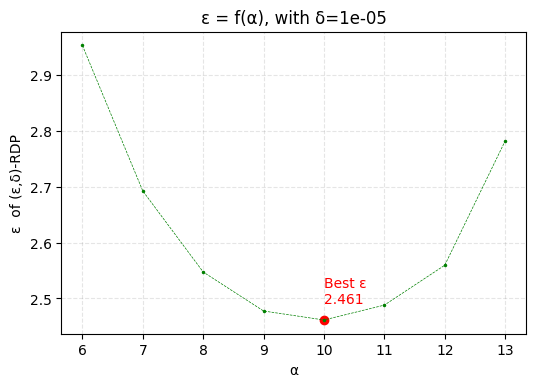

In [8]:
# One ε for each α (`epsilons`, `orders` are tensors)
epsilons = np.zeros_like(orders, dtype=float)

for i, alpha in enumerate(orders):
    rdp_eps = tf_privacy.compute_rdp(q, noise_multiplier, steps, alpha) 
    epsilons[i] = rdp_eps - np.log(delta) / (alpha - 1)

# Best ε index
min_index = np.nanargmin(epsilons)   # min ignoring NaN values

# Drawing  ε = f(α)  curve, near arround optimum
a = max(0, min_index - 4)
b = min(len(orders)-1, min_index + 4)

fig, ax = plt.subplots()

ax.plot(orders[a:b], epsilons[a:b], marker='.', markersize=3, ls = '--', linewidth=0.5, color='g')
ax.scatter(orders[min_index], epsilons[min_index], marker='o', color='r')
ax.text(orders[min_index], epsilons[min_index],f"Best ε\n{epsilons[min_index]:.4g}\n", color="red")

ax.set(title=f'ε = f(α), with δ={delta}', xlabel='α', ylabel='ε  of (ε,δ)-RDP')
ax.grid(color='gray', alpha=0.2, ls='--')

--- 
# Hyperparameters of the SGM & privacy
--- 
Let us illustrate the ε-cost dependence on different parameters (*one varying, with others kept to default values of the function*).

### Size of th training set

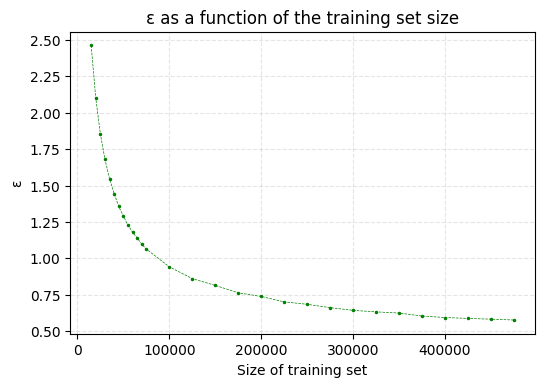

In [9]:
def eps_size(sz):
    """
    Returns epsilon parameter for `sz` training set size and other parameters to standard values.
    """
    return co.compute_dp_sgd_privacy(sz, 
                                     batch_size, 
                                     noise_multiplier, 
                                     epochs, 
                                     delta, 
                                     printed=False
           )[0]

 
# ===== Training set sizes =====
interval = list(range(15_000, 75_000, 5_000)) + list(range(75_000, 500_000, 25_000))

# Computation
sz = np.array(interval)
eps = np.zeros_like(interval, dtype=float)

for i, s in enumerate(interval):
    eps[i] = eps_size(s)

# Graph
fig, ax = plt.subplots()

ax.plot(sz, eps, marker='.', markersize=3, ls = '--', linewidth=0.5, color='g')

ax.set(title='ε as a function of the training set size', xlabel='Size of training set', ylabel='ε')
ax.grid(color='gray', alpha=0.2, ls='--')

### Batch size

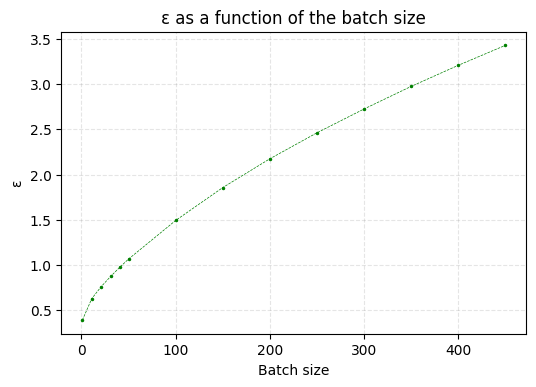

In [10]:
def eps_batch(bs):
    """
    Returns epsilon parameter for `bs` batch size and other parameters to standard values.
    """
    return co.compute_dp_sgd_privacy(dataset_size, 
                                     bs, 
                                     noise_multiplier, 
                                     epochs, 
                                     delta, 
                                     printed=False
           )[0]

 
# ===== Training set sizes =====
interval = list(range(1, 50, 10)) + list(range(50, 500, 50))

# Computation
bs = np.array(interval)
eps = np.zeros_like(interval, dtype=float)

for i, s in enumerate(interval):
    eps[i] = eps_batch(s)

# Graph
fig, ax = plt.subplots()

ax.plot(bs, eps, marker='.', markersize=3, ls = '--', linewidth=0.5, color='g')

ax.set(title='ε as a function of the batch size', xlabel='Batch size', ylabel='ε')
ax.grid(color='gray', alpha=0.2, ls='--')

### Batch size _vs_ number of epochs
Let us yet study this dependency for a fixed number of steps, i.e. a constant `batch_size / epochs` ratio. 

* _**Note : Weird irregularities** on the graph are because of impossibility to keep this ratio strictly constant and the related rounding or the number of epochs._

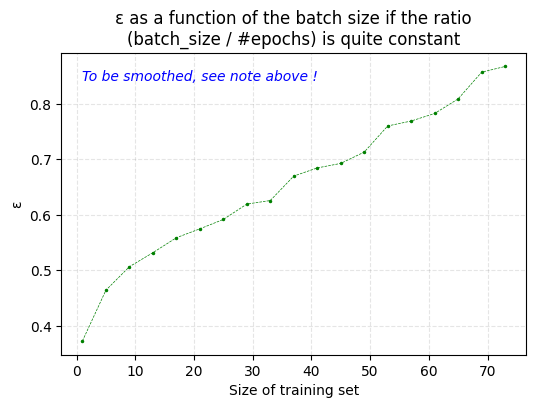

In [11]:
def eps_batch_ct_ratio(bs):
    """
    Returns epsilon parameter for `bs` batch size.
    
    Other parameters are set to standard values, except `epochs`, 
    calculated in order to keep a constant 
    """
    return co.compute_dp_sgd_privacy(dataset_size, 
                                     bs, 
                                     noise_multiplier, 
                                     # Minimum 1 epoch
                                     max(1,int(epochs * bs / batch_size)), 
                                     delta, 
                                     printed=False
           )[0]

# ===== Training set sizes =====
interval = list(range(1, 75, 4))# + list(range(50, 400, 100))

# Computation
bs = np.array(interval)
eps = np.zeros_like(interval, dtype=float)

for i, s in enumerate(interval):
    eps[i] = eps_batch_ct_ratio(s)

# Graph
fig, ax = plt.subplots()

ax.plot(bs, eps, marker='.', markersize=3, ls = '--', linewidth=0.5, color='g')

ax.set(title='ε as a function of the batch size if the ratio\n'
             '(batch_size / #epochs) is quite constant',
       xlabel='Size of training set', 
       ylabel='ε'
)

# Note
x_txt = np.min(bs)
y_txt = np.min(eps) + (np.max(eps) - np.min(eps)) * 19 / 20
ax.text(x_txt, y_txt, "To be smoothed, see note above !", style='italic', color='b')

ax.grid(color='gray', alpha=0.2, ls='--')

### Noise multiplier σ

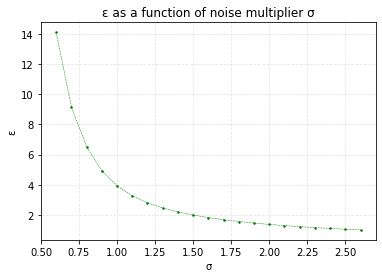

In [16]:
def eps_sigma(std):
    """
    Returns epsilon parameter for `std` noise multiplier and other parameters to standard values.
    """
    return co.compute_dp_sgd_privacy(dataset_size, 
                                     batch_size, 
                                     std, 
                                     epochs, 
                                     delta, 
                                     printed=False
           )[0]

 
# ===== Noise mutlipliers =====
interval = [0.6 + i/10 for i in range(21)]    

# Computation
std = np.array(interval)
eps = np.zeros_like(interval, dtype=float)

for i, sig in enumerate(interval):
    eps[i] = eps_sigma(sig)

# Graph
fig, ax = plt.subplots()

ax.plot(std, eps, marker='.', markersize=3, ls = '--', linewidth=0.5, color='g')

ax.set(title='ε as a function of noise multiplier σ', xlabel='σ', ylabel='ε')
ax.grid(color='gray', alpha=0.2, ls='--')

### Number of epochs

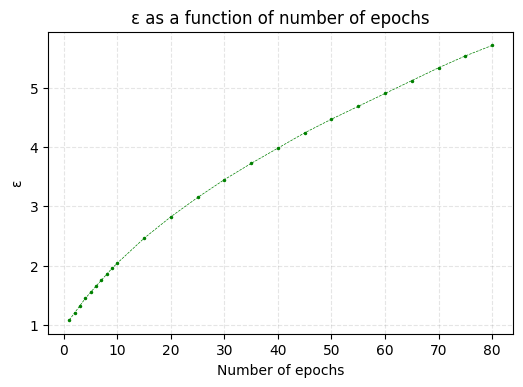

In [13]:
def eps_epochs(n_epochs):
    """
    Returns epsilon parameter for `n_epochs` number of epochs and other parameters to standard values.
    """
    return co.compute_dp_sgd_privacy(dataset_size, 
                                     batch_size, 
                                     noise_multiplier, 
                                     n_epochs, 
                                     delta, 
                                     printed=False
           )[0]

 
# ===== Numbers of epochs =====
interval = list(range(1,11)) + [i for i in range(15, 81, 5)]    

# Computation
epcs = np.array(interval)
eps = np.zeros_like(interval, dtype=float)

for i, epc in enumerate(epcs):
    eps[i] = eps_epochs(epc)

# Graph
fig, ax = plt.subplots()

ax.plot(epcs, eps, marker='.', markersize=3, ls = '--', linewidth=0.5, color='g')

ax.set(title='ε as a function of number of epochs', xlabel='Number of epochs', ylabel='ε')
ax.grid(color='gray', alpha=0.2, ls='--')

### Delta

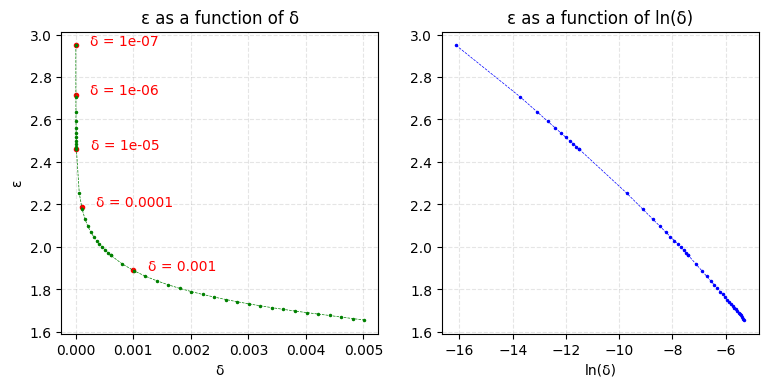

In [14]:
def eps_delta(d):
    """
    Returns epsilon parameter for `d` as delta and other parameters to standard values.
    """
    return co.compute_dp_sgd_privacy(dataset_size, 
                                     batch_size, 
                                     noise_multiplier, 
                                     epochs, 
                                     d, 
                                     printed=False
           )[0]

 
# ===== Deltas =====
interval = ([ i * 1e-7 for i in range(1, 102, 10)] 
            + [ i * 1e-5 for i in range(1, 62, 5)]    
            + [ i * 1e-5 for i in range(61, 502, 20)]    
)

# Computation
deltas = np.array(interval)
eps = np.zeros_like(interval, dtype=float)

for i, d in enumerate(deltas):
    eps[i] = eps_delta(d)

# Graph

# Wider for two graphs
dim_memo = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = plt.rcParams['figure.figsize'] * np.array([1.5, 1.0])

fig = plt.figure()
#fig, _ = plt.subplots(ncols=2)

ax = fig.add_subplot(121)   # 1 row × 2 col, #1
ax2 = fig.add_subplot(122)

ax.plot(deltas, eps, marker='.', markersize=3, ls = '--', linewidth=0.5, color='g')
ax.set(title='ε as a function of δ', xlabel='δ', ylabel='ε')
ax.grid(color='gray', alpha=0.2, ls='--')

ax2.plot(np.log(deltas), eps, marker='.', markersize=3, ls = '--', linewidth=0.5, color='b')
ax2.set(title='ε as a function of ln(δ)', xlabel='ln(δ)')
ax2.grid(color='gray', alpha=0.2, ls='--')

# Specific points
h_space = (np.max(deltas) - np.min(deltas))/20
for mag in [m for m in [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3] 
                  if np.min(deltas) <= m <= np.max(deltas)]:
    ep = eps_delta(mag)
    ax.scatter(mag, ep, marker='.', color='r')
    ax.text(mag + h_space , ep, "δ = "+str(mag), color='r')

# Restore default dimensions
plt.rcParams['figure.figsize'] = dim_memo

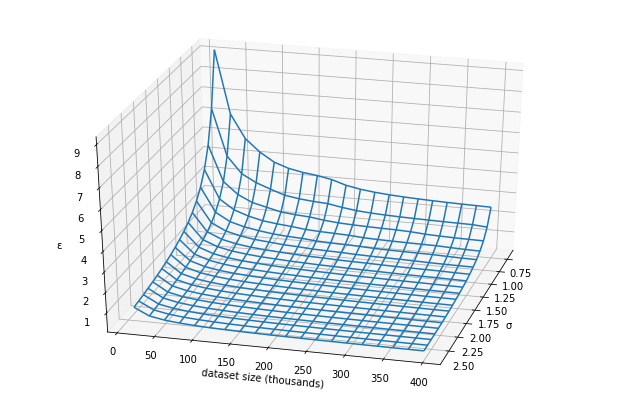

In [15]:
# ===== Training set sizes =====
interval = list(range(15_000, 400_000, 20_000))
sz = np.array(interval)

# ===== Noise mutlipliers ===== 
interval = [0.7 + i/10 for i in range(20)]
std = np.array(interval)

# Computing ε

# Tip: set to `already_done = True` to redraw graph without calculating data again
already_done = False
if not already_done:
    eps = np.zeros_like(np.outer(sz, std)) # Cartesian product
    for x, si in enumerate(sz):
        for y, st in enumerate(std):
            eps[x][y] = co.compute_dp_sgd_privacy(int(si), batch_size, float(st), epochs, delta, printed=False)[0]

    x, y = np.meshgrid(std, sz)       

# 3D graph

# Switch mode to add / remove interaction
%matplotlib inline
#%matplotlib ipympl

# Wider scale
dim_memo = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = plt.rcParams['figure.figsize'] * np.array([1.8, 1.8])

ax = plt.axes(projection='3d')
ax.set(xlabel='σ', ylabel="dataset size (thousands)", zlabel='ε')

# Rotation (degrees)
ax.view_init(30, 15)

surf = ax.plot_wireframe(x, y/1000, eps)
#surf = ax.plot_surface(x, y/1000, eps, linewidth=2, cmap='winter')

# Restore default dimensions
plt.rcParams['figure.figsize'] = dim_memo